# Finding Similar Items

## 1.	Introduction

### Mining information from Text Data 

-	This project will explore and analyze the information stored in a particular dataset. In this case the ACL Anthology dataset (https://aclanthology.org/). We will explore different techniques for obtaining valuable information.

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

   1. Compare the performance in time and the results for *k*-shingles = 3, 5 and 10, for the three methods and similarity thresholds *s*=0.1 and 0.2. Use 50 hashing functions. Comment your results. 
      
   2. Compare the results obtained for MinHash and LSH for different similarity thresholds *s* = 0.1, 0.2, 0.25 and 50, 100 and 200 hashing functions. Comment your results.
   
   3. For MinHashing using 100 hashing functions and *s* = 0.1 and 0.2,  find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each *s*. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?
 

-	Define all and only used package imports below

In [1]:
import requests # to download the dataset
import gzip
import shutil # to extract the gz file
import re # for text cleaning

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 

from nltk.corpus import stopwords # calculation of stopwords
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import itertools
from time import time
import binascii

from sklearn.neighbors import NearestNeighbors

nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.	ELT

### Extract, Load and Transform of data.



- In your code data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.

In [2]:
# Download data 
url = 'https://aclanthology.org/anthology+abstracts.bib.gz'
fname = "anthology+abstracts.bib"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# Extract the gz file
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
# Find all the rows in the file that contain an abstract and laod the text to a list
abstracts = []
with open(fname, "r",encoding="UTF-8") as f:
    s = f.readlines()
    for x in s:
        if x.__contains__('abstract'):
            start = x.find('   abstract = "') + len('   abstract = "')
            end = x.find('",')
            substring = x[start:end]
            abstracts.append(substring)
    f.close()

print("{} abstracts were found in the file.".format(len(abstracts)))

30807 abstracts were found in the file.


In [4]:
# Some cleaning

minletters = 200 
abstracts_clean = []

for a in abstracts: 
    if len(a) > minletters and len(re.findall('[a-zA-Z]',a)) >0.5*len(a):
        abstracts_clean.append(a) 
print("After cleaning, {} abstracts were remaining.".format(len(abstracts_clean)))

After cleaning, 30304 abstracts were remaining.


### Report the essential description of data.
-	Don’t print out dozens of raw lines.

In [5]:
data = pd.DataFrame(abstracts_clean, columns=['abstracts'])
# Number of words
data['word_count'] = data['abstracts'].apply(lambda x: len(str(x).split(" ")))
data[['abstracts','word_count']]

#Number of characters
data['char_count'] = data['abstracts'].str.len() ## this also includes spaces
data[['abstracts','char_count']]

# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['abstracts'].apply(lambda x: avg_word(x))

# Number of stop words 
stop = stopwords.words('english')
data['stopwords'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of Uppercase words
data['upper'] = data['abstracts'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Descriptive statistics of the DataFrame
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,30304.0,132.226703,43.194451,22.000000,102.000,130.000000,159.000000,1077.000000
char_count,30304.0,912.612691,293.737347,201.000000,709.000,903.000000,1098.000000,7265.000000
avg_word,30304.0,5.934332,0.462530,4.151786,5.625,5.891304,6.184503,13.545455
stopwords,30304.0,43.461358,19.129994,0.000000,32.000,43.000000,55.000000,384.000000
upper,30304.0,2.354871,2.798999,0.000000,0.000,1.000000,3.000000,34.000000


In [6]:
text = " ".join(abstracts for abstracts in data.abstracts.astype(str))
print ("There are {} words in the combination of all cells in column abstracts.".format(len(text)))
stopwords = set(STOPWORDS)

# to exclude certain words
stopwords.update(["a", "about", "above", "after", "again", "against", "all", 'also' "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", 
             "by", 'can', "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", 
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", 
             "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", 
             "most", "my", "myself", 'no', 'not', "nor", "of", "on", "once", "only", "or", "other", "ought", "our", 
             "ours", "ourselves", "out", "over", "own", 's', "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", 
             "we'll", "we're", "we've", "were", 'will', "what", "what's", "when", "when's", "where", "where's", 
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", 
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "br", "one", "want", "come", 
             "gets","without", 'rather', "although", "will", "see", "even","make", "seem"])


There are 27686118 words in the combination of all cells in column abstracts.


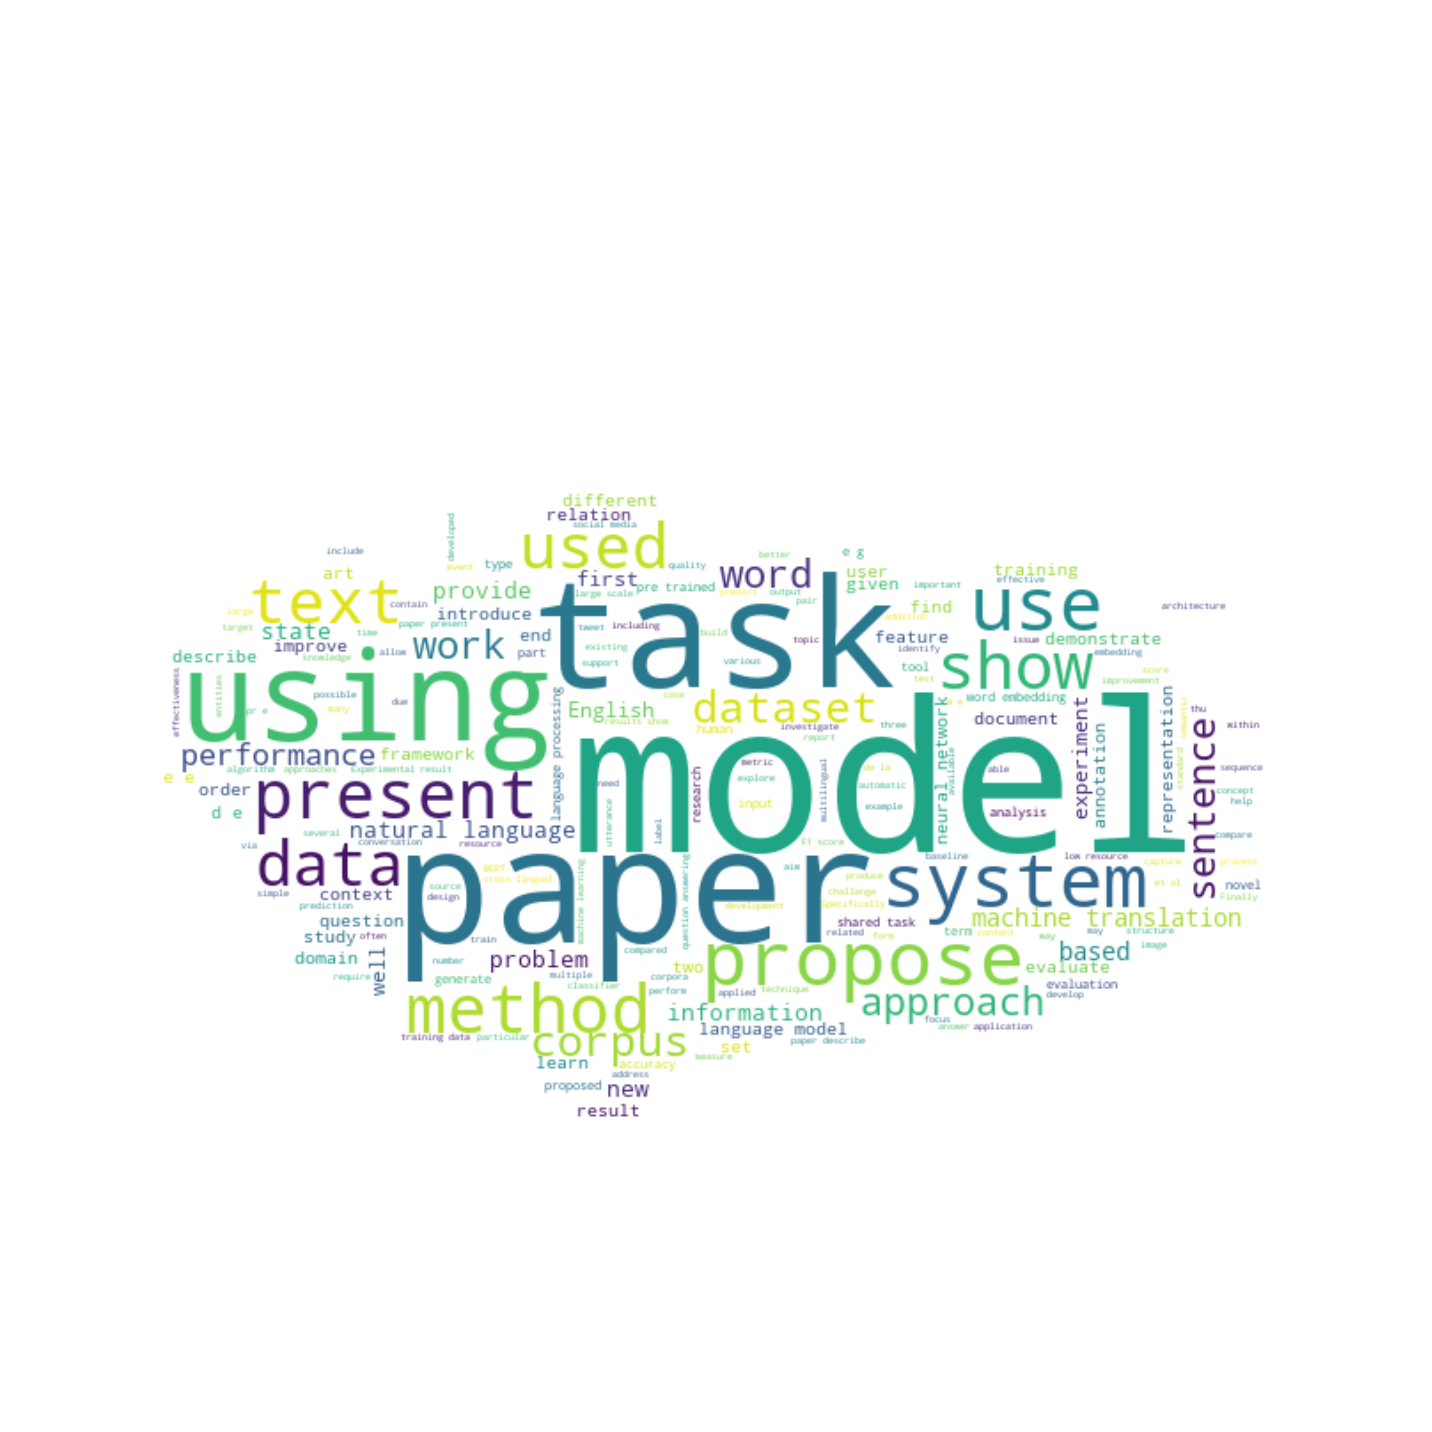

In [7]:
# Generate a word cloud image
from PIL import Image
from io import BytesIO
url = "https://thumbs.dreamstime.com/b/black-cloud-smoke-isolated-over-white-background-shape-illustration-102945454.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

mask = np.array(img)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=400, height=200, mask=mask).generate(text)

# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

## 3.	Modeling

### Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.

•	Avoid output.

•	Refactor your code until it’s clean

In [7]:
def get_shingles(text, k=5):
    """Get all shingles from requested file (hashes of these shingles)
    """
    L = len(text) # the length of each abstract
    shingles = set()  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = text[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) #& 0xffffffff  # hash the shingle to a 32-bit integer
        shingles.add(crc)
    return shingles       

In [8]:
def jaccard_similarity_score(x, y):
    """
    Jaccard Similarity J (A,B) = | Intersection (A,B) | /
                                    | Union (A,B) |
    """
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [9]:
# fast implementation of Minhash algorithm
# computes all random hash functions for a shingle at once, using vector operations
# also finds element-wise minimum of two vectors efficiently
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [10]:
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    """Locality Sensitive Hashing
    """
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [13]:
# set global parameters to process the whole dataset
bands = 10
rows = 10
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

random.seed(24) 
random.shuffle(abstracts_clean) # randomly shuffle the list of abstracts and then pick the first 1000
abstracts_random = abstracts_clean[:999]

In [39]:
# parameters
s_th = [0.1,0.2]
k_shingles = [3,5,10]


# Create slideframes to store the result
df_results_1 = pd.DataFrame(columns=["technique","s","k","t","pairs"])

for s in s_th:
    for k in k_shingles:
        signatures = []  # signatures for all abstracts
        
        t = time()
        
        #pair-wise jaccard-similarities    
        candidates = []

        for pair in itertools.combinations(abstracts_random,2):
            js = jaccard_similarity_score(get_shingles(pair[0], k=k),get_shingles(pair[1], k=k))

            if js > s:
                candidates.append(pair)
        t2 = time() - t
        df_results_1 = df_results_1.append({'technique': "Jaccard",'s': s, 'k': k, 't': t2, 'pairs': len(candidates)}, 
                 ignore_index=True)
        
        t = time()
        for abstract in abstracts_random: 
            
            shingles = get_shingles(abstract, k=k) # for minHash and LSH
            ShingleID = list(get_shingles(abstract, k=k))[0]
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig) # for minHash
            signatures.append(signature) 
        t_shingles = time() - t
        # find candidates with MinHash
        Nfiles = len(signatures)
    
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])  # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalente to Jaccard 
                    candidates.append((i,j))
        t_minhash = time() - t


        df_results_1 = df_results_1.append({'technique': "MinHash",'s': s, 'k': k, 't': t_minhash, 'pairs': len(candidates)}, 
                 ignore_index=True)

        # find candidates with LSH
        # prepare data for LSH
        t = time()
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors
        
        Nfiles = signatures.shape[1]  # number of different files
       
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t2 = time() - t + t_shingles

        df_results_1 = df_results_1.append({'technique': "LSH", 's': s, 'k': k, 't': t2, 'pairs': len(candidates)}, 
                 ignore_index=True)

KeyboardInterrupt: 

In [13]:
# parameters
s_th = [0.1,0.2,0.25]
bands = 10
r = [5,10,20]
k = 5 # we set k-Shingles equal to 5
# Create slideframes to store the result
df_results_2 = pd.DataFrame(columns=["technique","s","nsig","t","pairs"])

for rows in r:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions
    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    for s in s_th:
        
        signatures = []  # signatures for all abstracts
   
        t = time()
        for abstract in abstracts_random: 
            
            shingles = get_shingles(abstract, k=k) # for minHash and LSH
            ShingleID = list(get_shingles(abstract, k=k))[0]
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig) # for minHash
            signatures.append(signature) 
        t_shingles = time() - t
        # find candidates with MinHash
        Nfiles = len(signatures)
    
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])  # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalente to Jaccard 
                    candidates.append((i,j))
        t_minhash = time() - t


        df_results_2 = df_results_2.append({'technique': "MinHash",'s': s, 'nsig': nsig, 't': t_minhash, 'pairs': len(candidates)}, 
                 ignore_index=True)

        # find candidates with LSH
        # prepare data for LSH
        t = time()
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors
        
        Nfiles = signatures.shape[1]  # number of different files
       
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t2 = time() - t + t_shingles

        df_results_2 = df_results_2.append({'technique': "LSH", 's': s, 'nsig': nsig, 't': t2, 'pairs': len(candidates)}, 
                 ignore_index=True)

In [286]:
# set global parameters to process the whole dataset
bands = 10
rows = 10
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)



abstracts_random = abstracts_clean[:999]

df_results_3 = pd.DataFrame(columns=["s", "i", "j", "similarity"])
s_th = [0.1]
k = 5 # we set k-Shingles equal to 5
k_nn = [1,3,5]
# Create slideframes to store the result
Jdist = []

for s in s_th:
        
    signatures = []  # signatures for all abstracts
   
    t = time()
    for abstract in abstracts_random: 
            
        shingles = get_shingles(abstract, k=k) # for minHash and LSH
        ShingleID = list(get_shingles(abstract, k=k))[0]
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig) # for minHash
        signatures.append(signature) 
    t_shingles = time() - t
    # Jaccard similarity based on MinHash signatures
    Nfiles = len(signatures)
    jdist = []
    candidates = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = np.mean(signatures[i] == signatures[j])   
            if Jsim >= s: 
                jd = 1- jaccard_similarity_score(signatures[i], signatures[j])
                df_results_3 = df_results_3.append({'s': s, 'i': i, 'j': j, 'distance': jd}, 
                ignore_index=True)
                    

In [301]:
# Compute TF-IDF weights for Abstracts

def tokenize_and_stem(text):
    tokens = nltk.word_tokenize(text)
    stemmer = nltk.stem.porter.PorterStemmer()
    return [i for i in [stemmer.stem(t) for t in tokens] if len(i) > 2]
# Create vectorizer for Abstracts, max_df is set to 0.5, we only want
# to include terms that appear in less tha 50% of the documents (i.e. rare terms)
abs_tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=0, max_features=200000,
               stop_words='english', use_idf=True, tokenizer=tokenize_and_stem)
tfidf_weights_abs = abs_tfidf_vectorizer.fit_transform(abstracts_random)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
c:\users\alext\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'th

In [302]:
tfidf_weights_abs

<999x7660 sparse matrix of type '<class 'numpy.float64'>'
	with 56276 stored elements in Compressed Sparse Row format>

In [288]:
# filter rows for year does not equal to 2002
df_results_3_s01 = df_results_3[df_results_3.s != 0.2]
df_results_3_s02 = df_results_3[df_results_3.s != 0.1]

distances01 = df_results_3_s01.pivot(index="i", columns="j", values="similarity")


In [289]:
distances02 = distances02.fillna(1)
distances01 = distances01.fillna(1)

In [305]:
# Build model to return 5 closest neighbors
from sklearn.neighbors import NearestNeighbors

# Create the k-NN model using k=5
nn_abs = NearestNeighbors(n_neighbors=5, algorithm='auto')

# Fit the models to the TF-IDF weights matrix
nn_fitted_abs = nn_abs.fit(tfidf_weights_abs)

In [329]:
def find_nearest_papers(row, kNNmodel, tfidf_weights, abstracts):
    dist,idx = kNNmodel.kneighbors(tfidf_weights_abs[row,:])
    idx = list(idx[0])
    return {'papers':abstracts.iloc[idx]}

In [336]:
pd.set_option('display.max_colwidth', None)

## 4.	Results

-	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
-	Use minimum code here, just output-functions’ calls.

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

In [43]:
df_results_1

,technique,s,k,t,pairs
0,Jaccard,0.1,3,512.650351,491505
1,MinHash,0.1,3,10.948592,490660
2,LSH,0.1,3,5.739424,2
3,Jaccard,0.1,5,493.613429,3322
4,MinHash,0.1,5,13.199381,26591
5,LSH,0.1,5,7.772121,0
6,Jaccard,0.1,10,503.308553,4
7,MinHash,0.1,10,14.172727,3
8,LSH,0.1,10,8.895000,0
9,Jaccard,0.2,3,476.498739,289766


We can see that the naive method using the Jaccard similarities, takes a long time to run. As a relief on computation time the MinHash and LSH methods are much faster. We can see that the MinHash method manages to find quite a similar number of pairs as the naive method. However, even though the LSH is the fastest method to run, it does not manage to find similar pairs effectively. 

2. Compare the results obtained for MinHash and LSH for different similarity thresholds *s* = 0.1, 0.2, 0.25 and 50, 100 and 200 hashing functions. Comment your results.

In [16]:
df_results_2

,technique,s,nsig,t,pairs
0,MinHash,0.10,50,13.026464,36556
1,LSH,0.10,50,7.293763,1
2,MinHash,0.20,50,12.786444,146
3,LSH,0.20,50,7.240375,1
4,MinHash,0.25,50,12.744618,5
5,LSH,0.25,50,7.409819,1
6,MinHash,0.10,100,15.302062,27514
7,LSH,0.10,100,8.228721,1
8,MinHash,0.20,100,15.434122,27
9,LSH,0.20,100,9.607091,1


We can conclude that the number of hashing function plays a role on how many pair each method finds. For higher amount of hashing functions we receive fewer pairs of abstracts. The set of parameters that brings the result from the two methods is with similarity threshold equal to 0.25 and hashing functions equal to 100

   3. For MinHashing using 100 hashing functions and *s* = 0.1 and 0.2,  find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each *s*. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

In [337]:
find_nearest_papers(1, nn_fitted_abs, tfidf_weights_abs, pd.DataFrame(abstracts_random))

{'papers':                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

We took a different direction than what the task requested. Instead we find the nearest neighbors of a specific abstract and print them for examination. In the example printed above we can see that all articles have as a common theme as "summarization"

## 5.	Conclusions

We conclude that for this specific dataset the most efficient method for finding similar items is the the MinHash method. It is much faster than the naive method of finding similar items based on jaccard similarities, as well as it manages to find quite similar number of pairs of items as the naive method

In [1]:
! git add Mining_information.ipynb
! git commit -m "final comments"
! git push 

The file will have its original line endings in your working directory


[main 28f4750] final comments
 1 file changed, 174 insertions(+), 849 deletions(-)


To https://github.com/AlexTouvras/FindingSimilarItems
   a799901..28f4750  main -> main
